## Setup

In [1]:
!pip install poetry

In [2]:
!pip install https://github.com/parulsethi/SMorph/releases/download/v0.1.1-alpha/SMorph-0.1.1.tar.gz

In [3]:
on_colab = 'google.colab' in str(get_ipython())

if not on_colab:
    import napari
import smorph.util.autocrop as ac

import warnings
warnings.filterwarnings('ignore')

In [4]:
def view_3D(*args):  # Models a 3D image
    n_images = len(args)
    if not on_colab and n_images > 0:
        with napari.gui_qt():
            viewer = napari.view_image(**args[0])
            for itr in range(1, n_images):
                viewer.add_image(**args[itr])

## 1. Import Confocal Microscopic Image of the Tissue

Set `CONFOCAL_TISSUE_IMAGE` to the path of the image file to be processed.

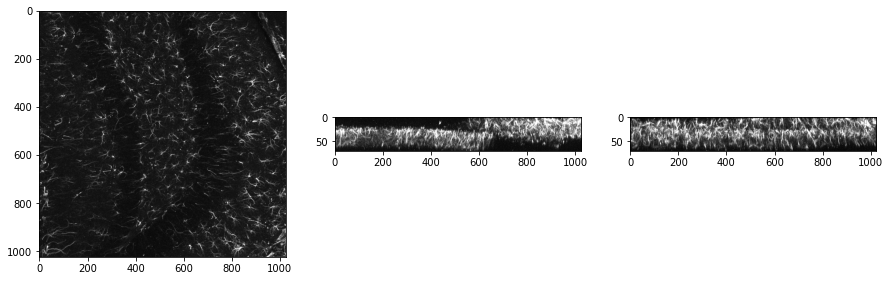

In [5]:
CONFOCAL_TISSUE_IMAGE = 'Datasets/SECTION 1_M1_LEFT/M1_LEFT _HILUS.lsm'

original = ac.import_confocal_image(CONFOCAL_TISSUE_IMAGE)
ac.projectXYZ(original, .5, .5, 1)

## 2. Non-local means denoising using auto-calibrated parameters

{'h': 0.0319707041900338, 'patch_size': 2, 'patch_distance': 2}


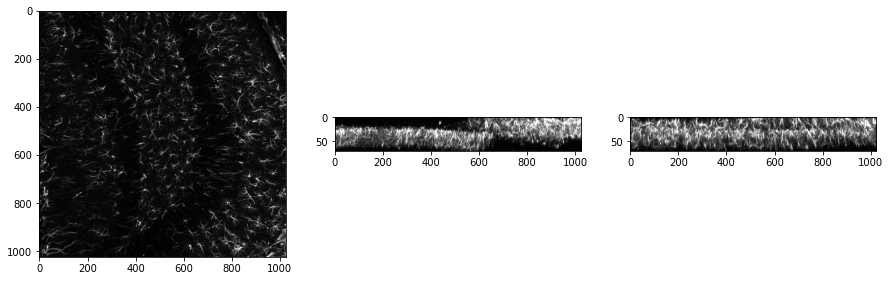

In [6]:
denoiser = ac.calibrate_nlm_denoiser(original)
denoise_parameters = denoiser.keywords['denoiser_kwargs']
print(denoise_parameters)
denoised = ac.denoise(original, denoise_parameters)
ac.projectXYZ(denoised, .5, .5, 1)

In [7]:
view_3D({'data': original, 'colormap': 'gray', 'name': 'original'},
        {'data': denoised, 'colormap': 'inferno', 'name': 'denoised'})

## 3. Segmentation

In [8]:
# Edge filtering to determine cell domains
edge_filtered = ac.filter_edges(denoised)

### 3.1 Threshold & color label cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

Understand their effect by configuring 3 parameters:
- `LOW_DELTA`: Pixel intensity value corresponding to change in `LOW_THRESH`
- `HIGH_DELTA`: Pixel intensity value corresponding to change in `HIGH_THRESH`
- `N_STEPS`: Number of steps of delta in threshold to take in both directions

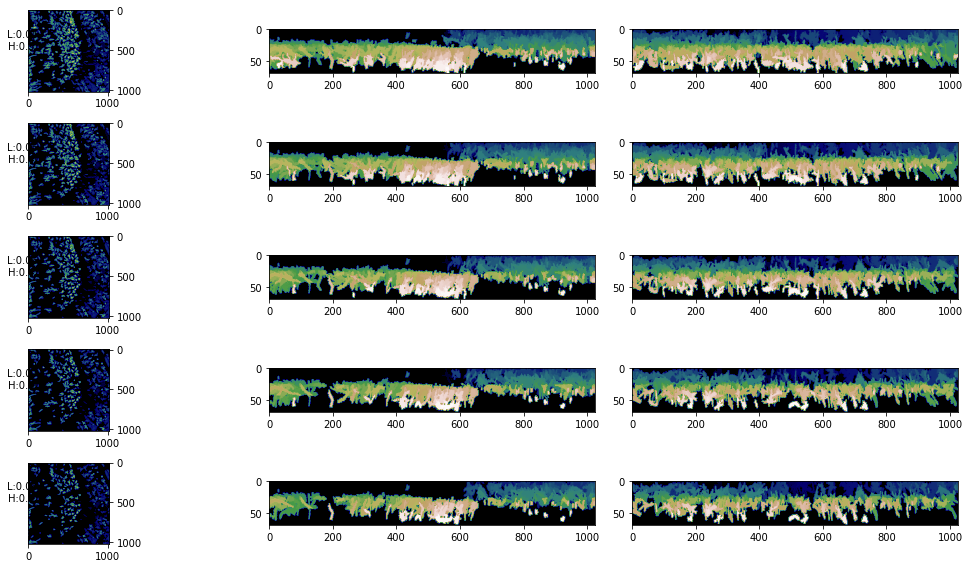

In [9]:
LOW_THRESH = .06
HIGH_THRESH = .45

LOW_DELTA = .01
HIGH_DELTA = .05
N_STEPS = 2

results = ac.testThresholds(edge_filtered, .5, .5, 1, 'gist_earth',
                            LOW_THRESH, HIGH_THRESH, LOW_DELTA, HIGH_DELTA, N_STEPS)
view_3D({'data': denoised, 'colormap': 'inferno', 'name': 'denoised'}, *results)

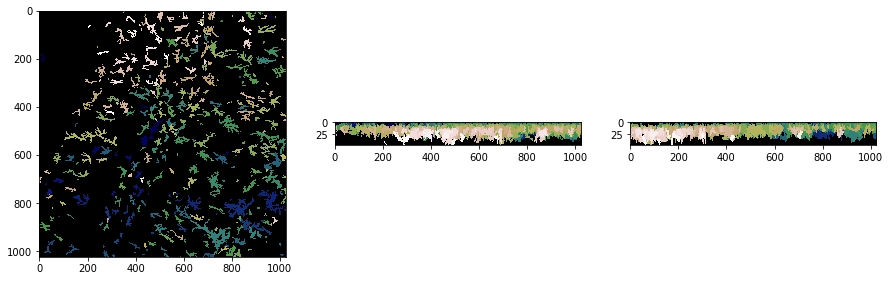

In [27]:
thresholded = ac.threshold(edge_filtered, LOW_THRESH, HIGH_THRESH)
labels = ac.label_thresholded(thresholded)

ac.projectXYZ(labels, .5, .5, 1, 'gist_earth')

In [28]:
view_3D({'data': original, 'name': 'original'},
        {'data': denoised, 'colormap': 'inferno', 'name': 'denoised'},
        {'data': labels, 'colormap': 'gist_earth', 'gamma': .8, 'name': 'labels'})

### 3.2 Filter segmented individual cells by removing ones in borders (touching the convex hull)

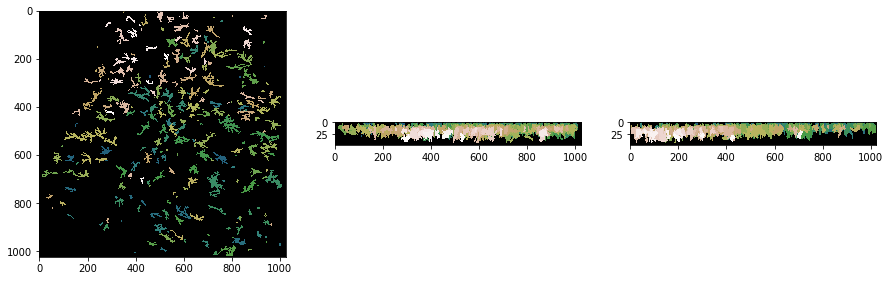

In [7]:
# Find convex hull that approximates tissue structure
convex_hull = ac.compute_convex_hull(thresholded)

# discard objects connected to border of approximated tissue, potential partially captured
filtered_labels = ac.filter_labels(labels, convex_hull)
ac.projectXYZ(filtered_labels, .5, .5, 1, 'gist_earth')

In [25]:
view_3D({'data': filtered_labels, 'name': 'filtered_labels'},
        {'data': labels, 'colormap': 'gist_earth', 'name': 'labels'},
        {'data': convex_hull, 'colormap': 'yellow', 'name': 'convex_hull'})

### 3.3 Visualize segmented cells to determine cutoff volumes

#### 3.3.1 Check batches of objects

In [8]:
regions = ac.arrange_regions(filtered_labels)

N_BATCHES = ac.paginate_objs(regions, pg_size=50)

267 objects detected.
There will be 6 batches, set `BATCH_NO` from 0 to 5 inclusive


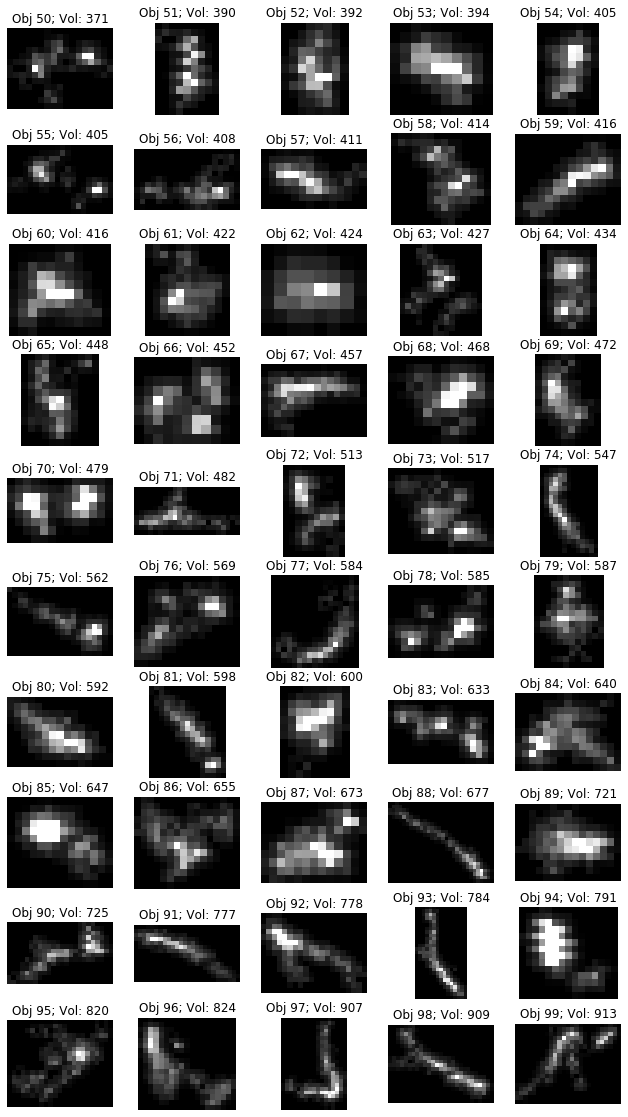

In [9]:
# Set `BATCH_NO` to view detected objects in paginated 2D MIP views.
BATCH_NO = 1
ac.project_batch(BATCH_NO, N_BATCHES, regions, denoised)

#### 3.3.2 Check individual objects
Select individual objects using `OBJ_INDEX`.

Volume of this object is: 2614


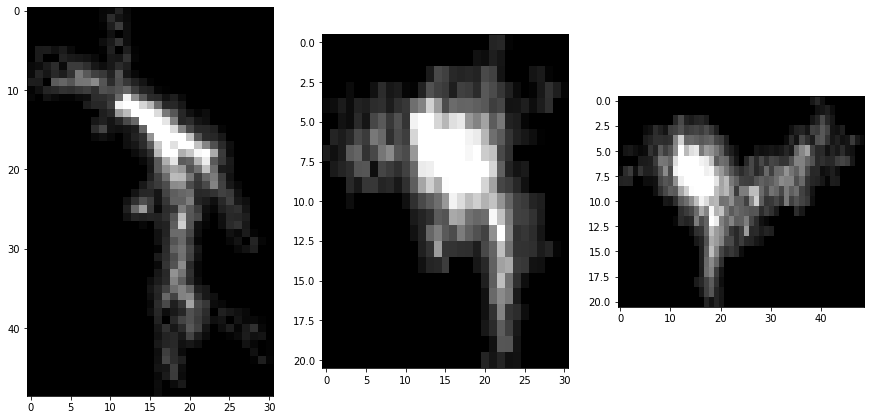

In [10]:
OBJ_INDEX = 175

extracted_cell = ac.extract_obj(regions[OBJ_INDEX], denoised)
minz, miny, minx, maxz, maxy, maxx = regions[OBJ_INDEX].bbox
ac.projectXYZ(extracted_cell, .5, .5, 1)

In [24]:
view_3D({'data': denoised[minz:maxz, miny:maxy, minx:maxx], 'name': 'denoised'},
        {'data': regions[OBJ_INDEX].image, 'colormap': 'yellow', 'name': 'thresholded'},
        {'data': extracted_cell, 'colormap': 'inferno', 'name': 'extracted_cell'})

## 4. Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = 0 for 3D cells, or
- Set `OUTPUT_OPTION` = 1 for Max Intensity Projections.

In [11]:
from os import getcwd, listdir, mkdir, path
from read_roi import read_roi_zip
from skimage import img_as_float, img_as_ubyte
from shutil import rmtree
import numpy as np
import tifffile

ROI_FILE = r'crop manual\M3_LEFT_ML_CELL CROP\RoiSet_LB_CELLS.zip'
rois = read_roi_zip(ROI_FILE)

points = rois[list(rois)[1]]

if points['type'] != 'point':
    raise ValueError('Cannot read points from ROI zip file')


def export_cells(
    img_path,
    low_vol_cutoff,
    hi_vol_cutoff,
    output_option,
    denoised,
    regions
):
    OUT_TYPE = ('3D', 'MIP')[output_option]

    DIR = getcwd() + '/autocropped/'
    if not (path.exists(DIR) and path.isdir(DIR)):
        mkdir(DIR)

    IMAGE_NAME = path.basename(img_path).split('.')[0]
    OUT_DIR = DIR + IMAGE_NAME + f'_{OUT_TYPE}/'
    if path.exists(OUT_DIR) and path.isdir(OUT_DIR):
        rmtree(OUT_DIR)
    mkdir(OUT_DIR)

    if img_path.split('.')[-1] == 'tif':
        with tifffile.TiffFile(img_path) as file:
            metadata = file.imagej_metadata

        cell_metadata = {}
        cell_metadata['unit'] = metadata['unit']
        cell_metadata['spacing'] = metadata['spacing']
        cell_metadata = json.dumps(cell_metadata)
    else:
        cell_metadata = None

    for (obj, region) in enumerate(regions):
        if low_vol_cutoff < region.area < hi_vol_cutoff:
            minz, miny, minx, maxz, maxy, maxx = region.bbox

            for i in range(len(points['x'])):
                if (minx <= points['x'][i] <= maxx) and (miny <= points['y'][i] <= maxy):
                    segmented = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
                    segmented = img_as_ubyte(segmented)
                    segmented[~region.filled_image] = 0

                    out = segmented if OUT_TYPE == '3D' else np.max(segmented, 0)

                    name = (f'{OUT_DIR}cell{obj}-({minx},{miny},{minz}),'
                            f'({maxx},{maxy},{maxz}).tif')
                    tifffile.imsave(name, out, description=cell_metadata)

In [12]:
LOW_VOLUME_CUTOFF = 0  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = 1e9  # filter cell clusters

OUTPUT_OPTION = 1  # 0 for 3D cells, 1 for Max Intensity Projections

export_cells(CONFOCAL_TISSUE_IMAGE, LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, denoised, regions)